# TP 03 - Couvertures d'un portefeuille obligataire
---
On détient un portefeuille V contenant quatre obligations corporates émises en Euro, de nominal 100. Les obligations versent toute un coupon annuel à une même date.
- Compagnie des Alpes, coupon 3.504 euros, maturité 24/10/2027, prix de marché 113
- Korian, coupon 3.70, maturité 07/10/2025, prix de marché 110.23
- Carrefour,coupon 1, maturité 27/10/2027, prix de marché 102.22
- Total, coupon 1.023, maturité 27/10/2027, prix de marché 106.57

Les titres sont équipondérés dans le portefeuille.

__L’objectif du TP__ est de construire un portefeuille qui permettra de convrir nos titres contre les variations de la courbe des taux. La table data_tp3.csv contient les courbes de taux souverains allemands et français.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import time
import math

from scipy.optimize import newton

import itertools #pour construire un iterator pour une def de matrice question 4 et 5

In [3]:
df= pd.read_csv("data_tp3.csv", sep= ';')
df.head()

,Maturity,rates,underlying,country,coupon
0,0.083333,-0.00597,AZ066741 Corp,Germany,0.0
1,0.250000,-0.00633,AZ923444 Corp,Germany,0.0
2,0.500000,-0.00617,ZR961307 Corp,Germany,0.0
3,1.000000,-0.00645,AU025425 Corp,Germany,0.0
4,2.000000,-0.00661,ZR204844 Corp,Germany,0.0


## Partie 1

### 1)
*Représentez, sur un même graphique les courbes zéro-coupons françaises et allemandes. Comment expliquez-vous les différences obtenues ?*

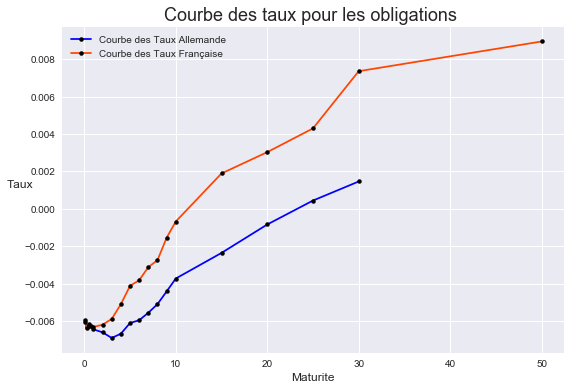

In [4]:
germany_data= df[df["country"] == "Germany"]
french_data= df[df["country"] != "Germany"]

mpl.style.use('seaborn')
fig, ax= plt.subplots(figsize= (9, 6))
plt.grid(b= True)

ax.plot(germany_data["Maturity"]
            ,germany_data["rates"]
            , marker= '.'
            , markerfacecolor= 'black'
            , markersize= 9
            , c= 'blue'
            , label= "Courbe des Taux Allemande")

ax.plot(french_data["Maturity"]
            ,french_data["rates"]
            , marker= '.'
            , markerfacecolor= 'black'
            , markersize= 9
            , c= 'orangered'
            , label= "Courbe des Taux Française")

ax.set_ylabel("Taux", rotation= 0, fontsize= 12)
ax.set_xlabel("Maturite", fontsize= 12)
ax.set_title("Courbe des taux pour les obligations ", fontsize= 18)
ax.legend()

plt.show()

#explication courbe des taux !!!!!!!!!

On peut voir que :

- La courbe des taux zéro coupons française est plus élevée que la courbe allemande (à l'exception des premières maturités), ce qui souligne le fait que les investisseurs ont moins confiance en les titres souverains allemands qu'en les titres français. En effet, l'obligation souveraine allemande est souvent utilisée en tant qu'actif sans risque sur le marché. Ainsi, le coût du financement pour la France est généralement supérieur à celui de l'Allemagne.
- De manière générale, les courbes zéro coupons sont croissantes, ce qui souligne que les investisseurs ont moins confiance en l'avenir lointain que proche.
- De manière locale, entre les maturités 0 à 5ans, la courbe des taux est décroissante : on parle d'inversement de la courbe des taux. Cela représente le fait que les investisseurs ont moins confiance à très court terme en l'avenir des pays évoqués. Ceci doit être dû à la conjoncture actuelle intégrant les éléments suivants :
 - Brexit
 - Tension US-Chine
 - Spectre de la déflation (faible inflation)
 - Politiques monétaires "mondiales" expansionnistes
- La maturité maximale pour les titres français est plus élevée que pour l'Allemagne. Cela est peut-être dû à la selection des données, il n'y a sûrement pas d'interprétation concrète.

### 2)
*Construire une dataframe contenant les flux de paiements reçus par échéances. Calculez le yield to maturity de chacune des positions, puis celle du portefeuille. Calculez ensuite sa duration (en fonction du yield to maturity).*

In [5]:
securities= pd.DataFrame({
    "Titre": ["Compagnie des Alpes", "Korian", "Carrefour", "Total"],
    "Coupon": [0.03504, 0.037, 0.01, 0.01023],
    "Prix": [113, 110.23, 102.22, 106.57],
    "Maturite": pd.to_datetime(["24/10/2027", "07/10/2025", "27/10/2027", "27/10/2027"],
                              format= '%d/%m/%Y')
})

date_aujourdhui= dt.datetime.strptime("25/10/2019", '%d/%m/%Y')
securities["Maturite"]= securities["Maturite"].apply(lambda x: (x.year - date_aujourdhui.year))

securities

,Titre,Coupon,Prix,Maturite
0,Compagnie des Alpes,0.03504,113.00,8
1,Korian,0.03700,110.23,6
2,Carrefour,0.01000,102.22,8
3,Total,0.01023,106.57,8


In [6]:
# Construction du portefeuille CASH FLOW
portefeuille_cashflow= pd.DataFrame({
    "Maturite": [i for i in range(1, np.max(securities["Maturite"].values) + 1)],
    "cash_flow": np.zeros(np.max(securities["Maturite"].values))
})
for i, val in securities.iterrows():
    for mat in range(val["Maturite"]):
        if mat != val["Maturite"] - 1:
            portefeuille_cashflow["cash_flow"][mat] += val["Coupon"]*100
        else:
            portefeuille_cashflow["cash_flow"][mat] += 100 + val["Coupon"]*100
portefeuille_cashflow

# Ce que nous a coûté la construction de ce portefeuille, c'est la somme des prix de nos actifs
prix_portefeuille= securities["Prix"].sum()
print(prix_portefeuille)
portefeuille_cashflow

C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


432.02000000000004


,Maturite,cash_flow
0,1,9.227
1,2,9.227
2,3,9.227
3,4,9.227
4,5,9.227
5,6,109.227
6,7,5.527
7,8,305.527


#### Calcul du yield du portefeuille

In [7]:
# Yield to maturity fonction pour le portefeuille cash flow
def f_cashflow(x, df, p, n=100):
    somme= 0
    
    for i in portefeuille_cashflow.index:
        C= portefeuille_cashflow.loc[i, "cash_flow"]
        somme += C*pow(x, i)
    return p - somme 


def fprime_cashflow(x, df, p, n=100):
    somme= 0
    
    for i in portefeuille_cashflow.index:
        C= portefeuille_cashflow.loc[i, "cash_flow"]
        somme += i*C*pow(x, i-1)
    return - somme

def yield_to_mat_cash_flow(f, x0, fprime, args):
    new= newton(func= f,x0=x0, fprime=fprime, args= args)
    return (1/new) - 1

In [8]:
portefeuille_y= yield_to_mat_cash_flow(f_cashflow, 1, fprime_cashflow, \
                                       (portefeuille_cashflow, prix_portefeuille))

portefeuille_y

0.012832386354566516

#### Calcul du yield pour les positions du portefeuille

In [9]:
from scipy.optimize import newton
def yield_to_maturity(P,c,T,N):
    """
    Renvoie le yield to maturity d'une obligation. Paramètres :
        - P : le prix de l'obligation
        - c : le taux de coupon de l'obligation
        - T : la maturité de l'obligation
        - N : le nominal de l'obligation
    """
    def f(x,P,c,T,N):
        """
        Approxime la fonction de cash flows. Paramètres :
            - x : la variable permettant l'optimisation par Newton
            - P : le prix de l'obligation
            - c : le taux de coupon de l'obligation
            - T : la maturité de l'obligation
            - N : le nominal de l'obligation
        """
        result = P
        for i in range(1,int(T)):
            result -= c*N*(x**i)
        result -= N*(1+c)*(x**T)
        return result
    
    def fprime(x,P,c,T,N):
        """
        Dérivée de l'approximation de la fonction de cash flows. Paramètres :
            - x : la variable permettant l'optimisation par Newton
            - P : le prix de l'obligation
            - c : le taux de coupon de l'obligation
            - T : la maturité de l'obligation
            - N : le nominal de l'obligation
        """
        result = 0
        for i in range(1,int(T)):
            result -= i*c*N*(x**(i-1))
        result -= T*N*(1+c)*(x**(T-1))
        return result
    
    x = newton(func=f,
           x0=1.1, # puisque y est de l'ordre 0.01 et que x = 1/(1+y) 1.1 semble etre un ordre de grandeur raisonable
           fprime=fprime,
           args=(P,c,T,N)
        )
    y = 1/x - 1
    return y

In [10]:
securities["Yield"]= securities.apply(lambda row: yield_to_maturity(row[2], row[1], row[3], 100), axis=1)

In [11]:
# Yield to maturity de toutes nos positions
securities

,Titre,Coupon,Prix,Maturite,Yield
0,Compagnie des Alpes,0.03504,113.00,8,0.017486
1,Korian,0.03700,110.23,6,0.018810
2,Carrefour,0.01000,102.22,8,0.007135
3,Total,0.01023,106.57,8,0.001945


In [12]:
portefeuille_cashflow

,Maturite,cash_flow
0,1,9.227
1,2,9.227
2,3,9.227
3,4,9.227
4,5,9.227
5,6,109.227
6,7,5.527
7,8,305.527


#### Calcul de la duration du portefeuille

In [13]:
def duration(df, y, n=100):
    somme= 0
    for i in portefeuille_cashflow.index:
        C= portefeuille_cashflow.loc[i, "cash_flow"]
        m= portefeuille_cashflow.loc[i, "Maturite"]
        somme -= m*C/pow(1+y, m+1)
    return somme#somme -(m*(n+C))/pow(1+y, (m+1))

print(duration(portefeuille_cashflow, portefeuille_y))
print("\nMC:")
print(duration(portefeuille_cashflow, portefeuille_y)/prix_portefeuille)

-2943.986751988242

MC:
-6.814468663460584


### 3)
*On appelle $D_i$ l’exposition du portefeuille à un mouvement du taux zéro-coupon i. L’exposition du portefeuille à l’ensemble des taux est $D =\sum_i D_i$ avec $D_i=\frac{\partial V_i}{\partial z_i}$ et $V_i=\frac{CF_i}{(1+z_i)^i}$*

*Calculez D pour les taux zéro-coupons allemands puis français. Comment expliquer la différence obtenue ? Pour les deux courbes de taux, à quelle maturité la duration est-elle la plus forte ? Pourquoi ?*

$V_i=\frac{CF_i}{(1+z_i)^i}=CF_i(1+z_i)^{-i}$

$D_i=\frac{\partial V_i}{\partial z_i} = -iCF_i(1+z_i)^{-(i+1)} = \frac{-iCF_i}{(1+z_i)^{i+1}}$

In [14]:
germany_data

,Maturity,rates,underlying,country,coupon
0,0.083333,-0.00597,AZ066741 Corp,Germany,0.00
1,0.250000,-0.00633,AZ923444 Corp,Germany,0.00
2,0.500000,-0.00617,ZR961307 Corp,Germany,0.00
3,1.000000,-0.00645,AU025425 Corp,Germany,0.00
4,2.000000,-0.00661,ZR204844 Corp,Germany,0.00
5,3.000000,-0.00691,AO131132 Corp,Germany,0.00
6,4.000000,-0.00668,AT634023 Corp,Germany,0.00
7,5.000000,-0.00611,AZ321298 Corp,Germany,0.00
8,6.000000,-0.00596,AF205634 Corp,Germany,1.00
9,7.000000,-0.00556,LW743065 Corp,Germany,0.00


In [15]:
def duration_i(y, C, m, n=100):
    return -(m*(1))/pow(1+y, (m+1))


In [16]:
#ici faut répondre à une question, la 3ème
french_data["Duration_i"]= french_data.apply(lambda row: duration_i(y=row[1], C=1, m=row[0], n=1)
                            , axis= 1)
germany_data["Duration_i"]= germany_data.apply(lambda row: duration_i(y=row[1], C=1, m=row[0], n=1)
                            , axis= 1)

french_data2= french_data[np.logical_and(french_data["Maturity"] <= 8, \
                                        french_data["Maturity"] >= 1)].reset_index(drop= True, inplace= False)
germany_data2= germany_data[np.logical_and(germany_data["Maturity"] <= 8, \
                                        germany_data["Maturity"] >= 1)].reset_index(drop= True, inplace= False)

#important !!
french_data2["Duration_i"]= french_data2["Duration_i"]*portefeuille_cashflow["cash_flow"]
germany_data2["Duration_i"]= germany_data2["Duration_i"]*portefeuille_cashflow["cash_flow"]

french_data2

C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Maturity,rates,underlying,country,coupon,Duration_i
0,1.0,-0.00632,ZQ078370 Corp,France,0.00,-9.344744
1,2.0,-0.00620,AW799417 Corp,France,0.00,-18.801545
2,3.0,-0.00589,AP173983 Corp,France,0.00,-28.342882
3,4.0,-0.00510,AT122915 Corp,France,0.00,-37.863727
4,5.0,-0.00412,ZS171522 Corp,France,0.00,-47.292085
5,6.0,-0.00382,UV715505 Corp,France,1.00,-673.157251
6,7.0,-0.00312,QZ358353 Corp,France,0.25,-39.668378
7,8.0,-0.00275,EJ346891 Corp,France,2.75,-2505.550600


## Remarque

Ici, la colonne `Duration_i` du dataframe `french_data2` représente la duration pour notre portefeuille ! On a bien utilisé les cashflows de notre portefeuille ! Si nous l'avons mis dans ce dataframe, c'est uniquement pour un cas de praticité.

In [17]:
# On print la somme des durations
print(germany_data2["Duration_i"].sum())
print(french_data2["Duration_i"].sum())
germany_data2

-3425.8022129274736
-3360.02121150659


,Maturity,rates,underlying,country,coupon,Duration_i
0,1.0,-0.00645,AU025425 Corp,Germany,0.0,-9.347190
1,2.0,-0.00661,ZR204844 Corp,Germany,0.0,-18.824834
2,3.0,-0.00691,AO131132 Corp,Germany,0.0,-28.459505
3,4.0,-0.00668,AT634023 Corp,Germany,0.0,-38.165821
4,5.0,-0.00611,AZ321298 Corp,Germany,0.0,-47.863075
5,6.0,-0.00596,AF205634 Corp,Germany,1.0,-683.367359
6,7.0,-0.00556,LW743065 Corp,Germany,0.0,-40.453754
7,8.0,-0.00510,AO223542 Corp,Germany,0.5,-2559.320674


## Remarque

Ici, la colonne `Duration_i` du dataframe `germany_data2` représente la duration pour notre portefeuille ! On a bien utilisé les cashflows de notre portefeuille ! Si nous l'avons mis dans ce dataframe, c'est uniquement pour un cas de praticité.

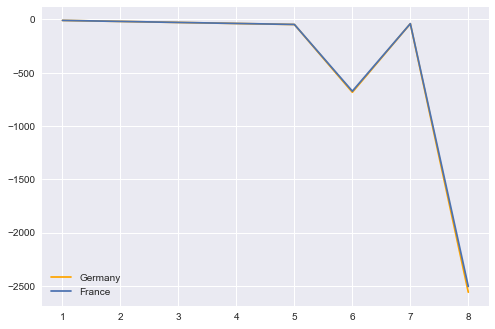

In [18]:
plt.plot(germany_data2["Maturity"], germany_data2["Duration_i"], label= "Germany", c="orange")
plt.plot(french_data2["Maturity"], french_data2["Duration_i"], label= "France")
plt.legend()
plt.show()

### Remarque:

Les durations sont peu différentes. La seule différence est le taux de nos obligations. Néanmoins, l'écart des taux est faible pour les maturités inférieures à 10. C'est pour ça que l'on constate ces courbes, qui pour notre échelle de maturité, semblent superposées.

Les durations sont les plus fortes aux 8emes et 6emes maturités, car ce sont les maturités lors desquelles nous recevons les nominaux des obligations.

### 4)
*On souhaite désormais couvrir le risque d’un mouvement de courbe des taux. Pour cela, on va shorter des obligations souveraines (on utilise les obligations présentes dans la Table data_tp3). Nous cherchons donc à nous immuniser contre 8 risques, correspondants aux 8 maturités de la courbe des taux. Pour cela, on considère 8 obligations souveraines : O1, ..., O8 et l’on cherche les quantités φ1, ...φ8 annulant un mouvement de la courbe des taux.*

*On pose D, le vecteur de durations du portefeuille aux maturités 1,...,8 : 
$D = \begin{bmatrix} D1 & ... & D8\end{bmatrix}$ ; Φ, le vecteur de quantités des actifs souverains $Φ = \begin{bmatrix}φ1 & ... & φ8\end{bmatrix}$ ; et $D_0$ la matrice carrée telle que :*

$D_0=\begin{bmatrix}
\frac{\partial O_1}{\partial z_1} & ... & \frac{\partial O_8}{\partial z_1} \\
... &  & ... \\
\frac{\partial O_1}{\partial z_8} & ... & \frac{\partial O_8}{\partial z_8}
\end{bmatrix}$

*On rappelle qui si $D_O$ est inversible, alors : $\Phi = -DD_0^{-1}$*

*Dans un premier temps, on cherche se couvrir contre des mouvements de taux 1 an et de taux 8 ans. On utilise les obligations souveraines correspondants aux maturités 1 et 8.
**Dans Python, utiliser les fonctions np.dot et np.linalg.inv**.*

In [19]:
french_data2

,Maturity,rates,underlying,country,coupon,Duration_i
0,1.0,-0.00632,ZQ078370 Corp,France,0.00,-9.344744
1,2.0,-0.00620,AW799417 Corp,France,0.00,-18.801545
2,3.0,-0.00589,AP173983 Corp,France,0.00,-28.342882
3,4.0,-0.00510,AT122915 Corp,France,0.00,-37.863727
4,5.0,-0.00412,ZS171522 Corp,France,0.00,-47.292085
5,6.0,-0.00382,UV715505 Corp,France,1.00,-673.157251
6,7.0,-0.00312,QZ358353 Corp,France,0.25,-39.668378
7,8.0,-0.00275,EJ346891 Corp,France,2.75,-2505.550600


In [20]:
def matrice_d_construction(df):
    """
    Me permet d'afficher une matrice triangulaire sup avec les cash_flow dans l'ordres de maturité
    Pour la 2 ème colonne, le cash flow s'arrète à partir de la 
    troisième ligne, avec une suite de 0.
    
    C'est un traitement nécessaire pour construire la matrice de dérivé par rapport à tous les taux
    obligataires
    
    Voici un exemple d'ouput:
                1.0	2.0	3.0	4.0	5.0	6.0	7.0	8.0
        0	100.0	0.0	0.0	0.0	0.0	1.0	0.25	2.75
        1	0.0	100.0	0.0	0.0	0.0	1.0	0.25	2.75
        2	0.0	0.0	100.0	0.0	0.0	1.0	0.25	2.75
        3	0.0	0.0	0.0	100.0	0.0	1.0	0.25	2.75
        4	0.0	0.0	0.0	0.0	100.0	1.0	0.25	2.75
        5	0.0	0.0	0.0	0.0	0.0	101.0	0.25	2.75
        6	0.0	0.0	0.0	0.0	0.0	0.0	100.25	2.75
        7	0.0	0.0	0.0	0.0	0.0	0.0	0.00	102.75
    """
    dicto= {i:np.array(np.repeat(df[df["Maturity"] == i]["coupon"], df.shape[0]))\
                    for i in df["Maturity"].values}
    
    test_df= pd.DataFrame.from_dict(dicto)
    test_matrix= pd.DataFrame.from_dict(dicto).to_numpy()
    #je rempli ma diagonal par la valeur du nominal (ici n=100)
    np.fill_diagonal(test_matrix, test_matrix.diagonal() + 100)
    df_out= pd.DataFrame(test_matrix, columns= [i for i in df["Maturity"].values])
    colname= df_out.columns
    #je met toutes les valeurs en dessous de la diagonale à 0
    return pd.DataFrame(np.triu(df_out, 0), columns= colname)

matrice_d_construction(french_data2)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
0,100.0,0.0,0.0,0.0,0.0,1.0,0.25,2.75
1,0.0,100.0,0.0,0.0,0.0,1.0,0.25,2.75
2,0.0,0.0,100.0,0.0,0.0,1.0,0.25,2.75
3,0.0,0.0,0.0,100.0,0.0,1.0,0.25,2.75
4,0.0,0.0,0.0,0.0,100.0,1.0,0.25,2.75
5,0.0,0.0,0.0,0.0,0.0,101.0,0.25,2.75
6,0.0,0.0,0.0,0.0,0.0,0.0,100.25,2.75
7,0.0,0.0,0.0,0.0,0.0,0.0,0.00,102.75


In [21]:
#rappel de la fonction
#pour ne pas oublier la façon dont je dois l'appeller
def duration_i(y, C, m):
    return -(m*(C))/pow(1+y, (m+1))

def matrice_d(df):
    """
    Sortie est la matrice n*n contenant la dérivé des n titres par rapports à leurs
    n taux
    -df : DataFrame qui doit contenir les colonnes suivantes: Maturity et coupon 
    (attention aux majuscules)
    """
    try_df= matrice_d_construction(df)

    iterator= itertools.product(df["Maturity"].index,
                               df["Maturity"].values)

    df_copy= df.copy()
    df_copy= df_copy.reset_index(drop= True, inplace= False)

    listed_stock= []
    for ite in iterator:
        m= ite[1]
        idx= ite[0]
        r= df_copy["rates"][idx]
        listed_stock.append(duration_i(r, try_df[m][idx], m))

    matrice_d_out= np.array(listed_stock).reshape(df.shape[0], df.shape[0])
    
    return matrice_d_out


def poids_couverture(matrice_d, vector_d):
    """
    Ressort le poids pour nous protéger contre les variations de la courbe des taux
    """
    return -np.dot(vector_d, np.linalg.inv(matrice_d))

In [22]:
#construison un df contenant que 2 titres = celui a la maturité 1an, et l'autre à la maturité 8ans
french_data_18= french_data2[np.logical_or(french_data2["Maturity"] == 1, french_data2["Maturity"] == 8)]
french_data_18= french_data_18.reset_index(drop= True)

#try
matrice_d_fr_18= matrice_d(french_data_18)
vecteur_d_fr_18= np.array(french_data_18["Duration_i"].values)
poids_couverture_18ans= poids_couverture(matrice_d_fr_18, vecteur_d_fr_18)
poids_couverture_18ans

array([-0.09227   , -2.97094826])

### Remarque

Les valeurs obtenue semblent correctes : elles sont bien négatives (pour se couvrir contre la variation des taux, on va shorter des titres souverains, donc un (-) est attendu).

Ainsi, pour se couvrir à la fois contre un risque variation des taux à 1 an et à 8 ans, il nous faudrait shorter 0.1 et 3 obligations souveraines françaises de maturité 1 an et 8 ans respectivement pour couvrir une unité de notre portefeuille (c'est à dire notre portefeuille).

### 5)
*Calculez désormais les quantités d’actifs nécessaires pour se couvrir contre une variation de l’ensemble de la courbe des taux.*

In [23]:
matrice_d_fr= matrice_d(french_data2)
matrice_d_fr
vecteur_d_fr= np.array(french_data2["Duration_i"].values)
poids= np.round(poids_couverture(matrice_d_fr, vecteur_d_fr), 5)
print(poids)

[-0.09227 -0.09227 -0.09227 -0.09227 -0.09227 -1.07683 -0.05126 -2.93036]


#### Remarque

*Voici les poids qui sont nécessaires pour couvrir notre portefeuille contre une variation de la courbe des taux.
Attention, ici, nous avons utilisé les obligations souveraines françaises et pas allemandes.*

## Partie 2
On souhaite désormais se couvrir en supposant que la courbe des taux est générée par le modèle de Vasicek. Dans ce cadre, la diffusion du taux court r<sub>t</sub> est donnée par :

$dr_t = a(b-r_t)dt + \sigma d W_t$ avec a > 0 la vitesse de retour à la moyenne, b la moyenne de long terme, σ > 0 l’écart-type et Wt un mouvement brownien.

Tout d’abord on souhaite approximer l’équation continue afin d’effectuer des simulations. On divise l’intervalle [0, T] en k intervalles de longueurs h tel que T = hk. Dans le cas où un intervalle dure un mois, alors h = 1 12 et k = 36 si T = 3.

Une version discrète est donnée par : $r_{t+1} = r_t + a(b-r_t)h + \sigma \sqrt{h} z_{t+1}$ avec $z_t$ ~ $N(0,1)$

### 1)
*Simulez des processus pour r0 = 0.01, a = 0.02, σ = 0.02, b = 0.005, h = 112 et k = 36. Puis pour a = 0.1. Qu’observez-vous ?*

In [24]:
def taux_vasicek_disc(r0, a, b, sig, h, k):
    r= [r0]
    i= 0
    for i in range(0, k):
        alea= sig*np.sqrt(h)*np.random.normal(0, 1, 1)
        retour= a*(b-r[i])*h
        r.append(r[i] + retour + alea)
    return r

In [25]:
np.random.seed(55)
data1= taux_vasicek_disc(0.01, 0.02, 0.005, 0.02, 1/12, 36)
data1

[0.01,
 array([0.00061705]),
 array([3.67058139e-05]),
 array([-0.01040386]),
 array([-0.00886175]),
 array([-0.00733781]),
 array([-0.00951745]),
 array([-0.00950647]),
 array([-0.00750998]),
 array([-0.002307]),
 array([-0.00437963]),
 array([0.0051995]),
 array([-0.00166559]),
 array([0.00796665]),
 array([-0.00360515]),
 array([-0.00634981]),
 array([0.00157187]),
 array([0.00306812]),
 array([0.00712637]),
 array([0.0122519]),
 array([0.01640955]),
 array([0.00841096]),
 array([0.00266956]),
 array([0.00169504]),
 array([0.0033632]),
 array([0.00508099]),
 array([0.00399788]),
 array([0.00187436]),
 array([0.01025564]),
 array([0.01151237]),
 array([0.01407143]),
 array([0.01284038]),
 array([0.00990071]),
 array([0.0122023]),
 array([0.01806491]),
 array([0.02503459]),
 array([0.0276177])]

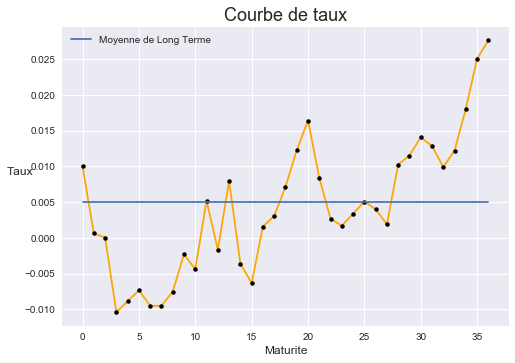

In [26]:
mpl.style.use('seaborn')
fig, ax= plt.subplots()

ax.plot([i for i in range(len(data1))]
            , np.ravel(data1)
            , marker= '.'
            , markerfacecolor= 'black'
            , markersize= 9
            , c= 'orange'
            )
b= 0.005
ax.plot([i for i in range(len(data1))]
        , [b for i in range(len(data1))]
        , label= "Moyenne de Long Terme"
       )

ax.set_ylabel("Taux", rotation= 0, fontsize= 12)
ax.set_xlabel("Maturite", fontsize= 12)
ax.set_title("Courbe de taux", fontsize= 18)
ax.legend()

plt.show()

### Remarque

C'est un modèle de modélisation des taux en continu. On considère qu'à long terme, notre taux = b et que les taux court fluctuent autour de cette moyenne de long terme. On considère aussi une vitesse de retour vers cette moyenne de long terme, a.

Dans notre plot, on remarque alors les taux semblent en effet fluctuer autours du seuil b=0.005.

In [27]:
np.random.seed(5)
data2= taux_vasicek_disc(0.01, 0.1, 0.005, 0.02, 1/12, 36)
data2

[0.01,
 array([0.01250576]),
 array([0.01053293]),
 array([0.02452089]),
 array([0.02290276]),
 array([0.0233864]),
 array([0.03236964]),
 array([0.02689211]),
 array([0.02329386]),
 array([0.02422454]),
 array([0.02215983]),
 array([0.0151304]),
 array([0.01386312]),
 array([0.01171756]),
 array([0.01514573]),
 array([0.00544952]),
 array([0.00140329]),
 array([0.00808082]),
 array([0.01877845]),
 array([0.00993883]),
 array([0.0136207]),
 array([0.00788732]),
 array([0.00291622]),
 array([-0.00210021]),
 array([-0.0044804]),
 array([0.00135156]),
 array([0.00549513]),
 array([0.00583247]),
 array([0.00372795]),
 array([0.00375754]),
 array([0.00315631]),
 array([0.00775037]),
 array([0.00408107]),
 array([0.00405296]),
 array([0.00347734]),
 array([0.00318802]),
 array([0.00464198])]

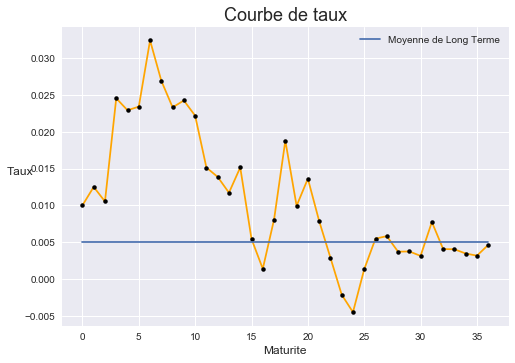

In [28]:
mpl.style.use('seaborn')
fig, ax= plt.subplots()

ax.plot([i for i in range(len(data2))]
            , np.ravel(data2)
            , marker= '.'
            , markerfacecolor= 'black'
            , markersize= 9
            , c= 'orange'
            )
b= 0.005
ax.plot([i for i in range(len(data2))]
        , [b for i in range(len(data2))]
        , label= "Moyenne de Long Terme"
       )

ax.set_ylabel("Taux", rotation= 0, fontsize= 12)
ax.set_xlabel("Maturite", fontsize= 12)
ax.set_title("Courbe de taux", fontsize= 18)
ax.legend()

plt.show()

### Remarque

On a donc augmenté notre vitesse de retour vers la moyenne de long terme. Toutes choses égales par ailleurs, on constate alors que les taux flanchent beaucoup plus rapidement vers notre b=0.005.

*Mais il ne faut pas oublier que le modèle est fondé sur un noyau aléatoire (distribution normale), donc on pourrait très bien ne pas avoir la même conclusion. 
C'est pourquoi, dans notre cas, nous avons décidé de fixer une seed, vers un résultat qui possède une explication qui nous paraissait censée.*

### 2)
*On appelle z(T) le taux zéro-coupon de maturité T tel que : $z(T)=z_\infty + s \frac{\Phi(T)}{T} + \frac{\sigma^2}{4a^3} \frac{\Phi(T)^2}{T}$ avec :*

- $z_\infty = b- \frac{\sigma^2}{2a^2}$
- $s = r_0 - z_\infty$ *où $r_0$ est le taux court vu en 0*
- $\Phi(T) = \frac{1-e^{-aT}}{a}$

*Pour le reste du TP, on considèrera le facteur d’actualisation à la maturité i sous sa forme continue i.e. $\frac{1}{(1+z_i)}$ devient $e^{-iz(i,z_\infty, s, \sigma^2)}$, et $z_i$ devient $z(i, z_\infty, s, \sigma^2)$*

### 3)
*Définir une fonction permettant de simuler une courbe de taux à partir de l’équation ci-dessus. Simuler une courbe de taux avec les paramètres suivants :*
- b=0
- r0=-0.005
- a=0.01
- sigma=0.001
- T=10
- une fréquence d’un an

*Qu’observez-vous ?*

In [29]:
def vasicek_new(T, b, r_0, a, sigma):
    """
    Retourne la valeur en T de la courbe de taux simulée par la nouvelle équation fournie après Vasicek.
    """
    z_infty = b - (sigma**2)/(2*a**2)
    s = r_0 - z_infty
    phi_T = (1-math.exp(-a*T))/a
    z_T = z_infty + s*phi_T/T + sigma**2 / (4*a**3) * phi_T**2 / T
    return z_T

In [30]:
#génération valeur pour la courbe
r0= -0.005
a= 0.01
b= 0
sig= 0.001
dico_courbe_taux ={
    i:vasicek_new(i, b, r0, a, sig) for i in range(1, 11)
}
dico_courbe_taux

{1: 0.242514521047985,
 2: 0.48511567351575857,
 3: 0.7228887393602974,
 4: 0.9559175512433539,
 5: 1.1842845172657772,
 6: 1.4080706452750393,
 7: 1.6273555667533413,
 8: 1.8422175602936797,
 9: 2.0527335746710125,
 10: 2.25897925151568}

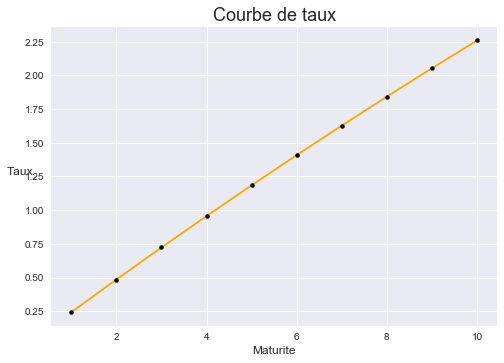

In [31]:
data= list(dico_courbe_taux.items())

mpl.style.use('seaborn')
fig, ax= plt.subplots()

ax.plot([i[0] for i in data]
            ,[i[1] for i in data]
            , marker= '.'
            , markerfacecolor= 'black'
            , markersize= 9
            , c= 'orange'
            )

ax.set_ylabel("Taux", rotation= 0, fontsize= 12)
ax.set_xlabel("Maturite", fontsize= 12)
ax.set_title("Courbe de taux", fontsize= 18)

plt.show()

### Remarque

On pourrait penser que notre fonction n'est pas bonne, mais si la courbe des taux ressemble à une fonction affine, c'est pour plusieurs raisons:

1. La vitesse de retour vers la moyenne de LT, a, est très faible

2. Notre moyenne de long terme b = 0. 

Ces 2 facteurs cumulés font en sorte que la force de montée est plus forte que notre force de rappel, au moins jusqu'à ce qu'on atteigne le taux = 10, alors à partir de ce moment, la pente de notre courbe est négative et on retourne bien vers notre b = 0.

Mais, si on modifie les extras paramètres qui sont fourni dans la consigne, (augmente b, augmente a, augmente r0 et sigma), on obtient bien une belle courbe de taux.

### 4)
On isole désormais les trois facteurs générant des mouvements de courbe des taux : z∞ (shift), s (pente), σ2 (torsion). Calculez et écrivez une fonction renvoyant : $\frac{\partial V_i}{\partial z_\infty}$, 
$\frac{\partial V_i}{\partial s}$,
$\frac{\partial V_i}{\partial \sigma^2}$. 
On supposera que $V_i = CF_i e^{-iz(i, z_\infty, s, \sigma^2)}$

$\frac{\partial V_i}{\partial z_\infty} = \frac{\partial(CFi e^{-iz(i, z_\infty, s, \sigma^2)})}{\partial z_\infty}$

$= CF_i *(-i)* \frac{\partial z(i, z_\infty, s, \sigma^2)}{\partial z_\infty} e^{-iz(i, z_\infty, s, \sigma^2)}$ avec $-i \frac{\partial z(i, z_\infty, s, \sigma^2)}{\partial z_\infty} = i(\frac{\Phi(T)}{T}-1)$

$\frac{\partial V_i}{\partial z_\infty} =  CF_i i(\frac{\Phi(T)}{T}-1) e^{-iz(i, z_\infty, s, \sigma^2)}$

In [32]:
def derivative_z_infty(CF_T, T, b, r_0, a, sigma):
    """
    Returns the derivative of V_T relative to z_infty.
    """
    phi_T = (1-math.exp(-a*T))/a
    return CF_T * T *(phi_T / T -1) * math.exp(-T * vasicek_new(T, b, r_0, a, sigma))

$\frac{\partial V_i}{\partial s} = \frac{\partial(CFi e^{-iz(i, z_\infty, s, \sigma^2)})}{\partial s}$

$= CF_i *(-i)* \frac{\partial z(i, z_s, s, \sigma^2)}{\partial z_s} e^{-iz(i, z_\infty, s, \sigma^2)}$ avec $\frac{\partial z(i, z_s, s, \sigma^2)}{\partial z_s} = \frac{\Phi(T)}{T}$

$\frac{\partial V_i}{\partial s} = CF_i (-i) \frac{\Phi(T)}{T} e^{-i z(i, z_\infty, s, \sigma^2)}$

In [33]:
def derivative_s(CF_T, T, b, r_0, a, sigma):
    """
    Returns the derivative of V_T relative to s.
    """
    phi_T = (1-math.exp(-a*T))/a
    return CF_T * -T * phi_T / T * math.exp(-T * vasicek_new(T, b, r_0, a, sigma))

$\frac{\partial V_i}{\partial \sigma^2} = \frac{\partial(CFi e^{-iz(i, z_\infty, s, \sigma^2)})}{\partial \sigma^2}$

$= CF_i (-i) \frac{\partial z}{\partial \sigma^2} e^{-iz(i, z_\infty, s, \sigma^2)}$ avec $\frac{\partial z}{\partial \sigma^2} = \frac{\partial z_\infty}{\partial \sigma^2} + \frac{1}{4a^3}$ et $\frac{\partial z_\infty}{\partial \sigma^2} = \frac{-1}{2a^2}$

$\frac{\partial V_i}{\partial \sigma^2} = CF_i (-i) (\frac{-1}{2a^2} + \frac{1}{4a^3}) e^{-iz(i, z_\infty, s, \sigma^2)}$

In [34]:
def derivative_sigma_2(CF_T, T, b, r_0, a, sigma):
    """
    Returns the derivative of V_T relative to s.
    """
    return CF_T * -T * (-1/(2*a**2) + 1/(4*a**3)) * math.exp(-T * vasicek_new(T, b, r_0, a, sigma))

### 5)
*On souhaite dans un premier temps couvrir le portefeuille contre une shift. Calculez la quantité d’obligation souveraine française maturité 1 an à vendre.*

In [35]:
derivative_z_infty(100, 10, b, r0, a, sig)

-7.481546556649866e-09

In [36]:
derivative_sigma_2(100, 1, b, r0, a, sig)

-19223982.66127721

In [37]:
derivative_sigma_2(9.227, 1, b, r0, a, sig)

-1773796.8801560483

In [38]:
# on va donc chercher à résoudre une équation à 1 inconnu (le nombre d'actif de couverture que nous devons
# détenir pour rendre insensible notre poretefeuille aux risque de shift)
v2 = derivative_z_infty(100, 1, b, r0, a, sig)
v1 = derivative_z_infty(9.227, 1, b, r0, a, sig)
-v1/v2

-0.09227

### Remarque

Ainsi, pour couvrir notre portefeuille contre le risque de court terme (${z_\infty}$), il nous faudrait shorter 1 dixième d'une obligation française de maturité 1 an ne versant pas de coupon.

Ce résultat n'est pas incohérent, car cette petite proportion est le résultat du faible cashflow généré par notre portefeuille par rapport à celui de l'obligation souveraine. 

### 6)
*Calculez les quantités d’actifs à vendre pour couvrir le portefeuille contre les trois risques. Vous utiliserez les obligations françaises de maturités 1 an, 5 ans et 7 ans.*

In [39]:
sigma_c= derivative_sigma_2(100.25, 7, b, r0, a, sig)
sigma_p= derivative_sigma_2(5.527, 7, b, r0, a, sig)
poids_c= -sigma_p/sigma_c
print("Il faut {} pour se convrir contre le risque de concavité".format(poids_c))

pente_lambda= derivative_s(100, 5, b, r0, a, sig)
pente_p= derivative_s(9.227, 5, b, r0, a, sig)
pente_c= derivative_s(0.25, 5, b, r0, a, sig)
poids_lambda= -(pente_p + pente_c*poids_c)/pente_lambda
print("\nIl faut {} pour se convrir contre le risque de pente".format(poids_lambda))


zoo_rho= derivative_z_infty(100, 1, b, r0, a, sig)
zoo_p= derivative_z_infty(9.227, 1, b, r0, a, sig)
zoo_c= derivative_z_infty(0.25, 1, b, r0, a, sig)
zoo_lambda= derivative_z_infty(0, 1, b, r0, a, sig)
poids_rho= -(zoo_p + poids_lambda*zoo_lambda + poids_c*zoo_c)/zoo_rho
print("\nIl faut {} pour se convrir contre le risque de shift".format(poids_rho))

Il faut -0.055132169576059854 pour se convrir contre le risque de concavité

Il faut -0.09213216957605985 pour se convrir contre le risque de pente

Il faut -0.09213216957605985 pour se convrir contre le risque de shift


### Remarque

Le raisonnement est le suivant:

On doit acheter 3 titres pour se convrir contre 3 types de riques (1an, 5ans et 7ans). On doit les acheter à la période 0, c'est à dire au moment ou on possède notre portefeuille. Ainsi, si on souhaite calculer la quantité de titre de CT nécessaire pour se couvrir contre le risque de $z_\infty$, je dois considérer le $z_\infty$ de mon portefeuille mais aussi celui des 3 autres titres de couverture.

Pour me protéger face au risque de PENTE, je dois considérer ce risque pour mon portefeuille, mais aussi pour mes 2 titres de converture restants (le titre de maturité 5ans et celui de 7ans, car le titre de maturité 1 an qui nous a servi d'outil de couverture contre le risque de $z_\infty$ n'existe plus à la maturité 5ans).

Finalement, pour se couvrir contre le risque de CONCAVITE, il ne reste qu'un seul titre, celui avec la maturité de 7ans. Je peux facilement calculer la quantité de ce titre nécessaire pour me couvrir contre le risque de CONCAVITE. Puis à rebourt, on peut déterminer les quantités de titre à shorter pour se couvrir contre le risque de PENTE et infine on trouve le nombre de titre pour se protéger contre le risque de $z_\infty$.
Avec cette approche, on admet une intéraction entre les titres de couvertures.

Cependant, les poids dans chacun des titres sont faible ce qui nous laisse penser que soit:
- notre méthode n'est pas la bonne ce qui expliquerai ces résultats (et donc possiblement, la question 5) serait aussi fausse).
- les extras paramètres (a, b, r0, sigma) qui nous ont été donné dans la consigne sont suffisament bizarre pour perturber nos résultats. Par bizarre, on part du principe que la moyenne de long terme du taux (b) est faible, tout comme la volatilité et la vitesse de retour à la normale (a).
- ou bien les 2 premiers points à la fois.